In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
merged_data_path = 'merged_df_24_11_10_only_exact_values.csv'

## 0. Importing Data

In [2]:
df_merged = pd.read_csv(merged_data_path, on_bad_lines='skip')

In [30]:
# Performing a copy of the dataset and showing columns information
df = df_merged.copy(deep=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095423 entries, 0 to 1095422
Data columns (total 6 columns):
 #   Column                                          Non-Null Count    Dtype  
---  ------                                          --------------    -----  
 0   Unnamed: 0                                      1095423 non-null  int64  
 1   Ligand SMILES                                   1095423 non-null  object 
 2   Target Name                                     1095423 non-null  object 
 3   BindingDB Target Chain Sequence                 1095423 non-null  object 
 4   UniProt (SwissProt) Entry Name of Target Chain  1095423 non-null  object 
 5   IC50 (nM)                                       1095423 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 50.1+ MB


## 1. Preprocessing

### 1.1 Grouping by Target Family
The goal is to read the "Target Name" entry of each protein to try to label the protein in the major families (e.g. kinase, receptor, etc.)

In [17]:

# Precompile regular expressions and organize them in a dictionary to improve search efficiency
categories = {
    "Kinase": re.compile(r'kinase|akt|mapk|cdk|jak|trk|src'),
    "Receptor": re.compile(r'receptor|gpcr|serotonin|dopamine|glutamate|adrenergic|opioid'),
    "Synthase": re.compile(r'synthase|synthetase|carboxylase|dehydratase'),
    "Ligase": re.compile(r'ligase|carboxylase|dna ligase'),
    "Oxidase": re.compile(r'oxidase|oxygenase|peroxidase|cytochrome'),
    "Transferase": re.compile(r'transferase|methyltransferase|phosphotransferase|acetyltransferase'),
    "Hydrolase": re.compile(r'hydrolase|phosphatase|protease|lipase|esterase|nuclease'),
    "Enzyme": re.compile(r'enzyme|dehydrogenase|isomerase|lyase'),
    "Ion Channel": re.compile(r'channel|ion channel|potassium|sodium|calcium|chloride'),
    "Transporter": re.compile(r'transporter|abc transporter|slc transporter|solute carrier'),
    "Chaperone": re.compile(r'chaperone|heat shock protein|hsp'),
    "Structural Protein": re.compile(r'actin|tubulin|collagen|elastin'),
    "Signaling Protein": re.compile(r'g-protein|adapter protein|scaffold protein'),
    "Antibody": re.compile(r'antibody|immunoglobulin|igg|igm|iga'),
    "Transcription Factor": re.compile(r'transcription factor|p53|nf-kb|homeobox|hox|forkhead'),
    "Growth Factor / Cytokine": re.compile(r'growth factor|cytokine|interleukin|tnf|vegf|egf|fgf'),
    "Protease Inhibitor": re.compile(r'protease inhibitor|serpin'),
    "Hormone": re.compile(r'hormone|insulin|glucagon|erythropoietin|epo'),
    "Viral Replicase Polyprotein": re.compile(r'replicase polyprotein 1ab|replicase polyprotein 1a'),
    "Viral Genome Polyprotein": re.compile(r'genome polyprotein'),
    "Huntingtin": re.compile(r'huntingtin')
}

# Function to categorize based on precompiled regex patterns
def categorize_targets(name):
    name = name.lower()
    for category, pattern in categories.items():
        if pattern.search(name):
            return category
    return "Other"

# Apply the function to your dataframe
df['Protein Family'] = df['Target Name'].apply(categorize_targets)

# Get counts by category
target_counts = df['Protein Family'].value_counts()
print(target_counts)


Protein Family
Other                          272671
Kinase                         258332
Receptor                       253697
Hydrolase                       86730
Oxidase                         46707
Ion Channel                     43854
Enzyme                          32064
Transferase                     31734
Synthase                        30129
Structural Protein               9731
Ligase                           7666
Viral Replicase Polyprotein      7009
Transporter                      5343
Viral Genome Polyprotein         2699
Chaperone                        2629
Antibody                         1388
Growth Factor / Cytokine         1310
Transcription Factor             1114
Huntingtin                        281
Signaling Protein                 254
Hormone                            45
Protease Inhibitor                 36
Name: count, dtype: int64


### 1.2 Identifying Unlabelled Proteins

In [18]:
df[df['Protein Family']== 'Other'][['Target Name', 'UniProt (SwissProt) Entry Name of Target Chain', 'Protein Family',]].sample(10)

,Target Name,UniProt (SwissProt) Entry Name of Target Chain,Protein Family
337779,Sialidase-2,NEUR2_HUMAN,Other
1012036,Stimulator of interferon genes protein [139-328],STING_MOUSE,Other
379619,Polyamine deacetylase HDAC10,HDA10_HUMAN,Other
1033929,Caspase-8,CASP8_HUMAN,Other
24778,"NAD-dependent protein deacetylase sirtuin-3, m...",SIR3_HUMAN,Other
929356,Carbonic anhydrase 2,CAH2_HUMAN,Other
211045,Acid ceramidase,ASAH1_HUMAN,Other
946722,Telomerase reverse transcriptase,TERT_HUMAN,Other
559207,Beta-secretase 2,BACE2_HUMAN,Other
928097,Metallo-beta-lactamase type 2,BLAN1_KLEPN,Other


### 1.3 Registering Protein Amino Acid Sequence Length

In [19]:
df['target_chain_length'] = df['BindingDB Target Chain Sequence'].str.len()

## 2. Plotting Explorations

### 2.1 Creating custom color maps for plotting purposes
The family "Other" (unclassified proteins) is assigned the lightgrey color for visualization purposes

In [20]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Retrieve the target families and then create a custom colormap
target_families = df['Protein Family'].astype('category').cat.categories
index_other = target_families.get_loc('Other')
colors = plt.cm.viridis(np.linspace(0, 1, len(target_families)))
colors[index_other] = mcolors.to_rgba('lightgrey')  # Set the color for "Other" to lightgrey

# Create the custom colormap based on the parameters defined above
custom_cmap = mcolors.ListedColormap(colors)
color_dict = {family: color for family, color in zip(target_families, colors)}

# Manual legend creation using patches for each target family
patches = [mpatches.Patch(color=colors[i], label=target_families[i]) for i in range(len(target_families))]

### 2.2 Histogram of Target Chain Lengths grouped by Target Family

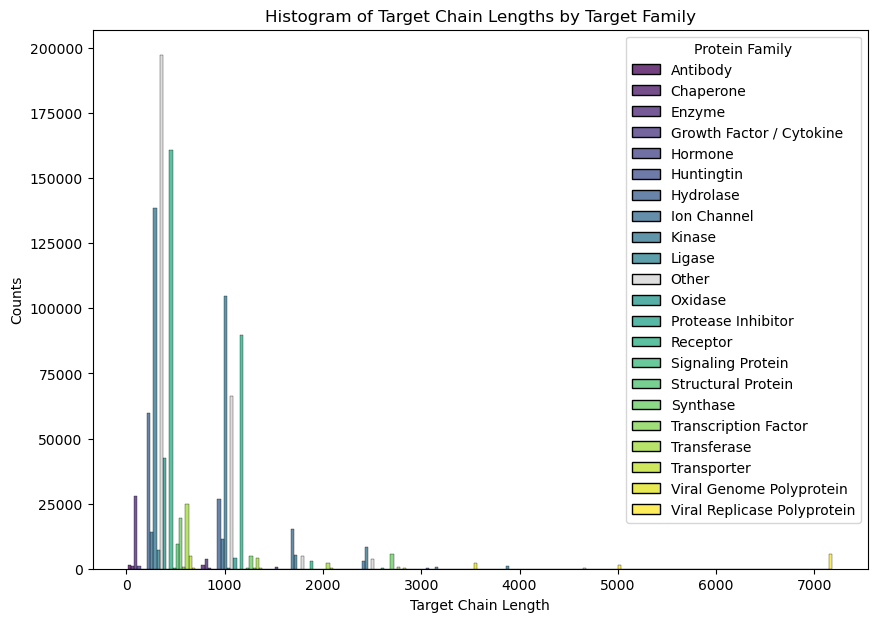

In [24]:
plt.figure(figsize=(10, 7))

# Variant A) PLotting that respects the alphabetical order
sns.histplot(data=df, x='target_chain_length', bins=10, hue='Protein Family', multiple='dodge', palette=color_dict, hue_order = color_dict.keys())

# Variant B) Plotting that respects the frequency order
#sns.histplot(data=df, x='target_chain_length', bins=10, hue='Target_family', multiple='dodge', palette=color_dict)

plt.title('Histogram of Target Chain Lengths by Target Family')
plt.xlabel('Target Chain Length')
plt.ylabel('Counts')
plt.show()

### 2.3 IC50 vs Target Chain Length

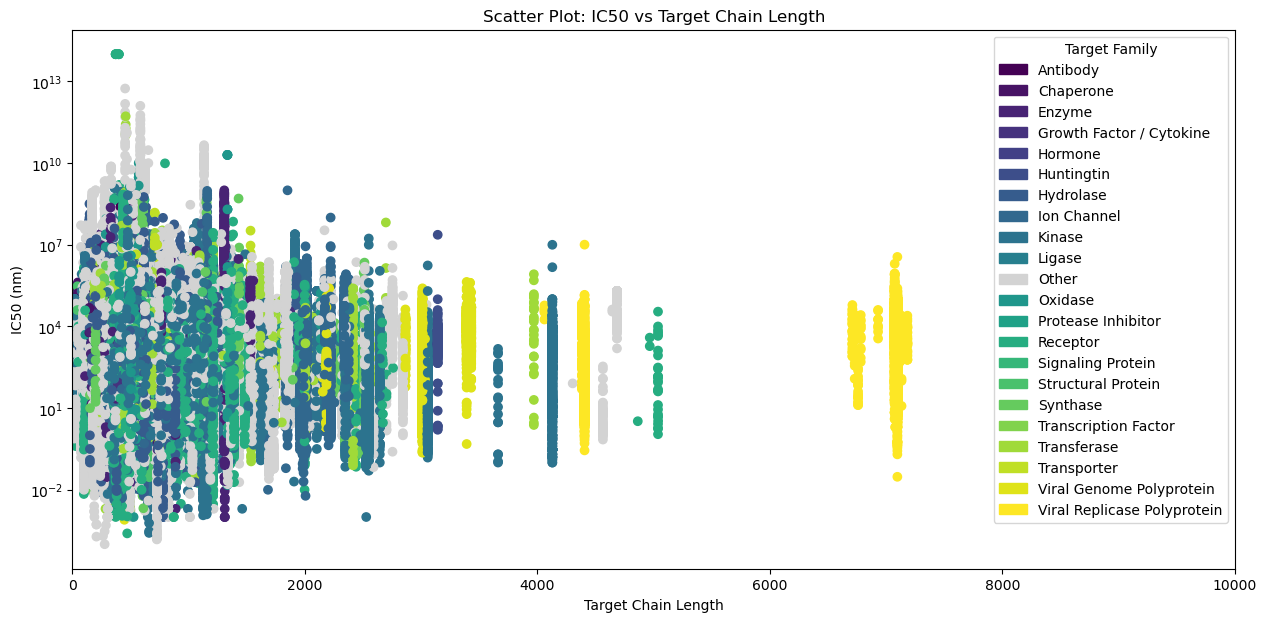

In [27]:
fig, ax = plt.subplots(figsize=(15, 7))

# Scatter plot with the custom colormap
scatter = ax.scatter(data=df, x='target_chain_length', y='IC50 (nM)',
                     c=df['Protein Family'].astype('category').cat.codes, cmap=custom_cmap)

ax.legend(handles=patches, title="Target Family", loc="upper right")

# Changing scales for plotting purposes
#ax.set_xscale('log')
ax.set_xlim([0, 1e4])
ax.set_yscale('log')

plt.title('Scatter Plot: IC50 vs Target Chain Length')
plt.xlabel('Target Chain Length')
plt.ylabel('IC50 (nm)')
plt.show()

#### 2.3.A Finding specific Protein Families 

In [28]:
df[(df['Protein Family'] == 'Other') & (df['target_chain_length'] > 3000)].sample(5)

,Unnamed: 0,Ligand SMILES,Target Name,BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50 (nM),Protein Family,target_chain_length
982025,982025,O=C(Nc1ccc(cc1)S(=O)(=O)N1CCOCC1)c1ccc(=O)[nH]c1,Plectin,MVAGMLMPRDQLRAIYEVLFREGVMVAKKDRRPRSLHPHVPGVTNL...,PLEC_HUMAN,11177.5000,Other,4684
739585,739585,Cc1cccc(C(=O)Nc2ccc3CCC(CCc3c2)NS(C)(=O)=O)c1-...,Apolipoprotein B-100,MDPPRPALLALLALPALLLLLLAGARAEEEMLENVSLVCPKDATRF...,APOB_HUMAN,5.0000,Other,4563
739620,739620,Cc1cccc(C(=O)Nc2ccc3C[C@H](Cc3c2)NS(=O)(=O)c2c...,Apolipoprotein B-100,MDPPRPALLALLALPALLLLLLAGARAEEEMLENVSLVCPKDATRF...,APOB_HUMAN,0.9000,Other,4563
204800,204800,CCCCn1c(NS(=O)(=O)c2ccccc2)c(c2nc3ccccc3nc12)S...,Plectin,MVAGMLMPRDQLRAIYEVLFREGVMVAKKDRRPRSLHPHVPGVTNL...,PLEC_HUMAN,100799.9355,Other,4684
236445,236445,CCN1CCN(CC1)c1nc2n(C)c(=O)[nH]c(=O)c2n1CC(C)=C,Plectin,MVAGMLMPRDQLRAIYEVLFREGVMVAKKDRRPRSLHPHVPGVTNL...,PLEC_HUMAN,200000.0000,Other,4684
